<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "ODC"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/Level3-SubCellType/ODC/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


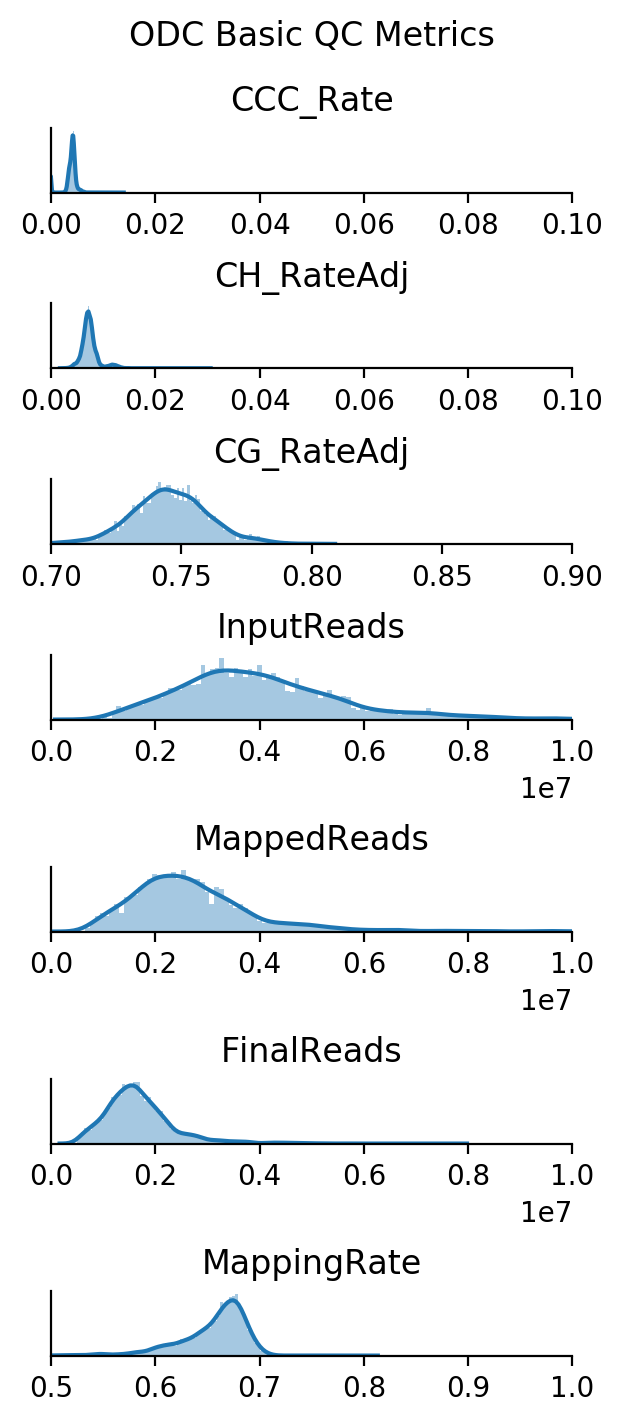

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

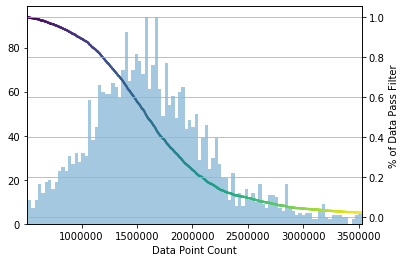

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 3082/3082 (100.0%)
CG_RateAdj passed 3082/3082 (100.0%)
CH_RateAdj passed 3082/3082 (100.0%)
FinalReads passed 3082/3082 (100.0%)
MappingRate passed 3082/3082 (100.0%)
Overall passed 3082/3082 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
171206 26
171207 28
171212 8
171213 38
171214 43
171219 58
180104 22
180109 43
180110 39
180111 34
180119 22
180122 14
180123 13
180129 13
180130 13
180205 14
180206 16
180208 27
180212 45
180213 10
180220 31
180222 28
180226 5
180227 7
180305 19
180306 25
180312 26
180313 12
180319 3
180320 34
180326 35
180329 29
180402 24
180403 47
180405 25
180409 11
180410 12
180412 32
180416 11
180417 27
180419 15
180423 42
180424 19
180426 44
180430 51
180501 28
180514 24
180529 35
180724 3
180806 27
180911 37
180917 11
180925 74
181002 39
181008 26
181009 40
181015 69
181016 55
181022 32
181023 42
181204 31
181206 82
181210 32
181218 28
181220 89
190108 49
190117 36
190122 51
190124 42
190131 14
190205 66
190207 41
190212 108
190214 96
190219 116
190305 53
190307 27
190625 41
190627 76
190711 174
190716 148


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 379 98.7%
ad002 392 102.1%
ad004 378 98.4%
ad006 392 102.1%
ad007 405 105.5%
ad008 379 98.7%
ad010 393 102.3%
ad012 364 94.8%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l1-umap_0,l1-umap_1,l1-tsne_0,l1-tsne_1,MajorType,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,PassFilter
cell,,,,,,,,,,,,,,,,,,,,,
10E_M_116,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.004406,0.745677,0.744551,0.012093,0.007720,1352223.0,3406212,2175142.0,10E,...,-24.171999,13.366199,32.018433,-27.104887,ODC,2.349343,-11.798378,37.474939,9.132037,True
10E_M_118,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.004403,0.741310,0.740166,0.011342,0.006970,1288597.0,3384916,2114331.0,10E,...,-24.340467,12.133686,28.071035,-27.882774,ODC,-1.537899,-8.593849,9.937055,10.539690,True
10E_M_119,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.004510,0.757342,0.756242,0.011958,0.007482,1539349.0,3958192,2505673.0,10E,...,-23.455709,13.886536,32.565229,-25.210470,ODC,2.200440,-12.401833,40.381912,11.922916,True
10E_M_120,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.004477,0.746806,0.745667,0.012476,0.008035,1909841.0,4821680,3145700.0,10E,...,-25.991644,15.020279,36.524645,-31.676036,ODC,3.826312,-8.358545,30.037189,-7.425379,True
10E_M_121,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.004216,0.739956,0.738855,0.010591,0.006401,1387404.0,3690756,2263809.0,10E,...,-24.049030,11.782579,27.490651,-27.284230,ODC,-2.554189,-8.684207,5.604488,12.799909,True
10E_M_1341,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.004295,0.756914,0.755865,0.011942,0.007680,1334663.0,3401216,2237085.0,10E,...,-23.685846,14.348316,33.980299,-25.924661,ODC,2.552046,-12.380036,39.885815,9.898457,True
10E_M_1532,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.003855,0.740866,0.739863,0.009733,0.005901,789983.0,2570252,1457407.0,10E,...,-24.097052,9.912419,23.956801,-27.883880,ODC,-5.000516,-9.048825,-3.453220,16.275818,True
10E_M_1533,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.003984,0.726839,0.725746,0.009587,0.005625,2103584.0,6048324,3813800.0,10E,...,-24.917896,12.054695,27.902996,-29.612076,ODC,-1.198901,-7.043818,5.747175,1.921463,True
10E_M_1534,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.004274,0.746145,0.745056,0.012176,0.007935,2249206.0,6426622,4066646.0,10E,...,-24.850527,14.468961,34.771115,-28.871526,ODC,3.228423,-9.658756,31.226461,2.594496,True
